# Portuguese Bank Marketing - Machine Learning



The data is associated with the direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a term deposit. The outcome of this classification can enable marketing teams to more accurately predict customer bases and therefore cut down on costs.

In [0]:
####################################################################################################################
#Importing relevant packages

import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.linear_model as linear
import random
sns.set(style="darkgrid")
plt.style.use('ggplot')
%matplotlib inline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
import datetime
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Loading the Dataset

The dataset comprizes of 21 features and 41,188 rows, including both categorical and numerical types. 

In [0]:
dataframe = pd.read_csv( "bank-additional-full.csv", sep=";")
dataframe.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
dataframe.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


# Data Cleaning and Exploration

The data itself needs very little cleaning. It has no null or NaN values. However, other features need to be adjusted. The feature 'pdays' indicates time elasped from the last contact attempt. If no contact was priorly made, we assigned 'pdays' value of 0 instead of 999

In [0]:
dataframe.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [0]:
dataframe['pdays'].replace(999,0, inplace = True)

In [0]:
## data exploration-value counting each feature to perform feature selection
object_list = []
number_list = []

def examine_data_frame( df):
    for name in df.columns:
        print ("----------")
        print (df[ name].dtype)
        if df[ name].dtype is np.dtype( 'O'):
            print (df[ name].value_counts())
            print ("Name: ", name)
        else:
            print (df[ name].describe())

examine_data_frame(dataframe)

----------
int64
count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64
----------
object
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
Name:  job
----------
object
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
Name:  marital
----------
object
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
Name:  education
----------
object
no         3

The feature 'education' comprises of 8 categories, including; 'basic.9y', 'basic.6y' and 'basic.9y'. In order to reduce the number of eventual features and the dimensionality of our model, we combine these into a single category; 'basic'.

In [0]:
dataframe.replace(['basic.6y','basic.4y', 'basic.9y'], 'basic', inplace = True)

## Feature Selection

Exploring the data suggests that we drop some features.The feature 'default' which indicates whether or not the individual has credit in default. Since there were only three individuals that had defaulted, we remove those observations from the dataset. 'Duration' is also dropped as it is only included in the dataset as a benchmark variable. Furthermore, one only knows the 'duration' of the telemarketing call after the fact so it is not a relevant variable.

In [0]:
##feature selection
dataframe['duration'].value_counts() 
dataframe.drop(['duration'], inplace = True, axis=1)

In [0]:
dataframe['default'].value_counts()
dataframe.drop(['default'], inplace = True, axis=1)

# Data Visualization

This section picks features that we hypothesize to be important for the model. We pick these features intuitively and observe their distribution across the data through visualizations.

y               no       yes
marital                     
divorced  0.100418  0.011557
married   0.543751  0.061474
single    0.241527  0.039332
unknown   0.001651  0.000291


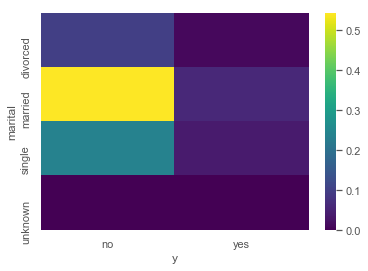

In [0]:
frequencies = pd.crosstab(dataframe["marital"], dataframe[ "y"]).apply(lambda r: r/len(dataframe))
print (frequencies)

sns.heatmap( frequencies,cmap = 'viridis')

Text(0, 0.5, 'Frequency')

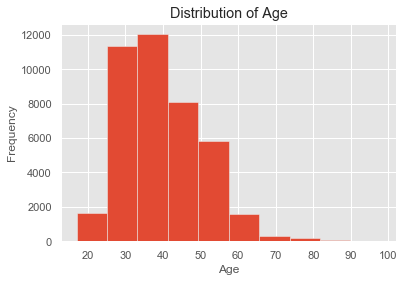

In [0]:
dataframe['age'].hist()
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

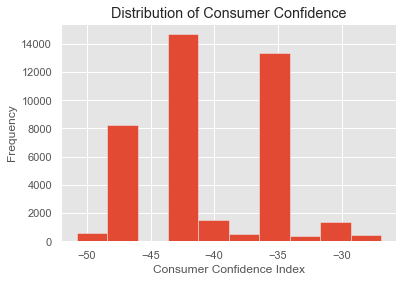

In [0]:
dataframe['cons.conf.idx'].hist()
plt.title("Distribution of Consumer Confidence")
plt.xlabel("Consumer Confidence Index")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

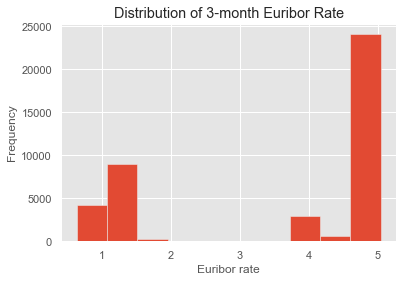

In [0]:
dataframe['euribor3m'].hist()
plt.title("Distribution of 3-month Euribor Rate")
plt.xlabel("Euribor rate")
plt.ylabel("Frequency")

# Feature Engineering and Final Data Cleaning

We then engineer new features by conducting a 'One-hot encoding' on all the categorical features in our dataset to convert them to numerical values. Furthermore, we normalize the data and this is the final step in cleaning our features. 

In [0]:
from sklearn.preprocessing import StandardScaler

numbers = ['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m','nr.employed']

obj_ss = StandardScaler()
vals = obj_ss.fit_transform(dataframe[numbers])
dataframe[numbers] = vals

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
dfo = pd.get_dummies(dataframe[dataframe.columns[:-1]])
dfo['y'] = dataframe['y']
dfo['y'] = dfo['y'].apply(lambda x: 1 if x =='yes' else 0)

In [0]:
dfo.shape

(41188, 58)

Seperating the Data into Training and Testing Sets

In [0]:
X = dfo.iloc[:,:-1]
y = dfo[dfo.columns[-1]]

In [0]:
>>> X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

Conducting PCA analysis to aid with feature selection

<Figure size 720x864 with 0 Axes>

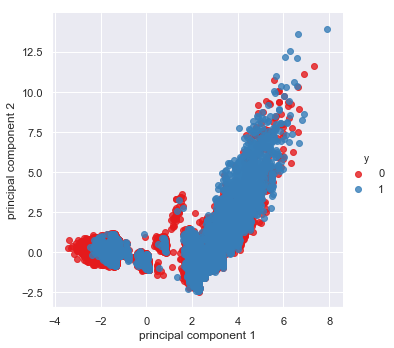

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
two_components = pca.fit_transform(X)
df_pca = pd.DataFrame(data = two_components
             , columns = ['principal component 1', 'principal component 2'])
df_pca['y'] = dfo['y'].values

sns.set()
sns.set_palette('Set1')
fig = plt.figure(figsize=(10,12))
sns.lmplot( x = 'principal component 1', y = 'principal component 2', hue = 'y', data = df_pca, fit_reg= False )
fig = plt.gcf()
fig.savefig('PCA.png',bbox_inches='tight' )

[ 28.29  37.87  46.    52.98  59.4   64.27  68.05  71.38  74.39  76.52
  78.48  80.36  82.18  83.86  85.31  86.71  88.08  89.43  90.67  91.66
  92.58  93.42  94.07  94.7   95.25  95.78  96.26  96.73  97.18  97.53
  97.86  98.19  98.47  98.71  98.94  99.13  99.3   99.43  99.55  99.66
  99.77  99.86  99.92  99.95  99.97  99.99 100.   100.   100.   100.
 100.   100.   100.   100.   100.   100.   100.  ]


Text(0, 0.5, 'Cumulative Variation Explained')

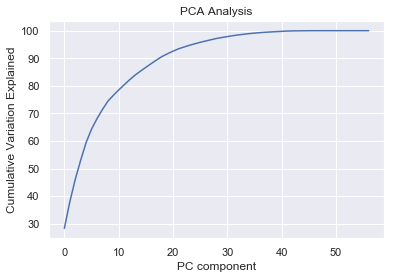

In [0]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline


pca = PCA(n_components=57)

pca.fit(dfo)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
    
var1 =np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)

plt.plot(var1)
plt.title("PCA Analysis")
plt.xlabel("PC component")
plt.ylabel("Cumulative Variation Explained")


# Defining the Models

In [0]:
# computational libraries
import numpy as np
import pandas as pd

import pickle

#Visualization Metrics
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import validation_curve, learning_curve

#Classification Algorithms
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import sklearn

#Metrics
from sklearn.metrics import accuracy_score, fbeta_score, classification_report, make_scorer, f1_score




from time import time


#Pipeline to run and test multiple ML algorithms
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
       
       outputs: dict['train_time', 'pred_time', 'acc_test', 'f_test']
    '''
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,  
    start = time() # Get start time
    predictions = learner.predict(X_test)
    end = time() # Get end time
    
    #Classification Report
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions)
    
    # Compute F-score on the test set. We use previous beta
    results['f_test'] = f1_score(y_test, predictions, labels=None,
    pos_label=1,
    average='weighted',
    sample_weight=None,

)
    
    report = classification_report(y_test,predictions)
       
        
    # Return the results
    return results, report

def complexity_curve(X_train, y_train, model, hyperparameter, param_range):
    
    from sklearn.metrics import fbeta_score, make_scorer
    
    #score = make_scorer(fbeta_score(y_train,2))
    
    
    
    '''Plot the complexity and learning curves for the model selected'''

    
    train_scores, test_scores = validation_curve( model, X_train, y_train, 
                                                 param_name=hyperparameter, param_range=param_range,
                                                 cv=5, scoring= 'accuracy', n_jobs=1)
    
    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

   
    #fig = plt.figure(figsize=(10,12))
    sns.set()
    # Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score", color="red")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

    # Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="lightcoral")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="lightgreen")

    # Create plot
    plt.title("Validation Curve")
    plt.xlabel(hyperparameter)
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
   

    fig = plt.gcf()
    fig.savefig('complexity.png',bbox_inches='tight')
    
    plt.show()
    
def learning_curve_(X_train, y_train, model):


    
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X_train, y_train,cv=5, scoring='f1_score',
                                                            n_jobs=-1)
# Number of folds in cross-validation
# Evaluation metric
# Use all computer cores

# 50 different sizes of the training set


    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    #fig = plt.figure(figsize=(10,12))
    sns.set()

    # Draw lines
    plt.plot(train_sizes, train_mean, color="red",  label="Training score")
    plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="lightcoral")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="lightgreen")

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    
    
    
    fig = plt.gcf()
    fig.savefig('learning_curve.png',bbox_inches='tight' )
    
    plt.tight_layout()
    plt.show()
    
    
    ################################
    

    

In [0]:
model_svm = SVC()
model_NB = GaussianNB()
model_KNN = KNeighborsClassifier(n_neighbors= 7)


results_svm, report_svm = train_predict(model_svm, X_train, y_train, X_test, y_test)
results_NB, report_NB = train_predict(model_NB, X_train, y_train, X_test, y_test)
results_KNN, report_KNN = train_predict(model_KNN, X_train, y_train, X_test, y_test)


results_svm = list(results_svm.values())
results_NB = list(results_NB.values())
results_KNN =  list(results_KNN.values())


results = np.vstack((results_svm,results_NB,results_KNN)
df_results = pd.DataFrame(results,columns = ['train_time', 'pred_time', 'acc_test', 'f_test'], 
                          index = ['SVM', 'NB', 'KNN'])

df_results_table = df_results.copy()


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [2]:
df_results

NameError: ignored

Computing Accuracies

In [1]:
#Accuracy

objects = ('SVM', 'NB', 'KNN')
y_pos = np.arange(len(objects))
performance = df_results['acc_test'].values

#fig = plt.figure(figsize=(10,12)
plt.bar(y_pos, performance, align='center',color=['red', 'green', 'blue', 'cyan', 'yellow'], 
        alpha= 0.7, edgecolor='black')
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
fig = plt.gcf()
fig.savefig('accuracy.png',bbox_inches='tight' )

NameError: ignored

In [0]:
print('\n', report_NB)


               precision    recall  f1-score   support

           0       0.93      0.91      0.92     12056
           1       0.40      0.45      0.42      1537

   micro avg       0.86      0.86      0.86     13593
   macro avg       0.66      0.68      0.67     13593
weighted avg       0.87      0.86      0.86     13593



In [0]:
print('\n'+report_KNN)


              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12056
           1       0.54      0.27      0.36      1537

   micro avg       0.89      0.89      0.89     13593
   macro avg       0.73      0.62      0.65     13593
weighted avg       0.87      0.89      0.87     13593



In [0]:
print('\n'+classification_report(y_test,gpred))


              precision    recall  f1-score   support

           0       0.91      0.99      0.95     12056
           1       0.69      0.19      0.30      1537

   micro avg       0.90      0.90      0.90     13593
   macro avg       0.80      0.59      0.62     13593
weighted avg       0.88      0.90      0.87     13593

